# Footprint rasters on s3

Paul Montesano, PhD

#### Note:  
 - to return the spatial extent of s3 raster paths  
 - needed for `build_stack`

In [3]:
!pip install -U contextily

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)


In [3]:
import s3fs
import os
import boto3
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
sys.path.append('/projects/code/geoscitools')
import footprintlib
import maplib
import CovariateUtils

import rasterio
import contextily as ctx
import requests
import glob

import rasterio as rio
from rasterio.windows import Window

/opt/conda/envs/pangeo/lib/python3.10/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


## Access to TerraPulse s3 bucket 

In [2]:
dict_list = [
    # TerraPulse unclipped annual boreal TCC
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'boreal-tcc-unclipped', 
     'search_tail_string': '/data/**/*y2019_dat.tif', # the year here can vary between 1984-2020; tiles should be exactly the same
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    },
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data/boreal-forest-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'forest_loss',#'tcc_pvalue',#'tcc_slope', #'tcc_2020', tcc_pvalue, forest_age, forest_loss
     'search_tail_string': '/**/*dat.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    }
]

In [3]:
s3 = s3fs.S3FileSystem(anon=True)

In [4]:
s3.ls('s3://terrapulse-pub-data')

['terrapulse-pub-data/boreal-forest-data',
 'terrapulse-pub-data/boreal-tcc-unclipped',
 'terrapulse-pub-data/index.html',
 'terrapulse-pub-data/kml',
 'terrapulse-pub-data/land']

In [5]:
s3.ls('s3://terrapulse-pub-data/boreal-forest-data')

['terrapulse-pub-data/boreal-forest-data/datasets_readme.pdf',
 'terrapulse-pub-data/boreal-forest-data/forest_age',
 'terrapulse-pub-data/boreal-forest-data/forest_loss',
 'terrapulse-pub-data/boreal-forest-data/tcc_2020',
 'terrapulse-pub-data/boreal-forest-data/tcc_pvalue',
 'terrapulse-pub-data/boreal-forest-data/tcc_slope']

In [6]:
fn_list_main = s3.glob('s3://terrapulse-pub-data/boreal-tcc-unclipped/data/**/*.tif')

In [7]:
fn_list = s3.glob('s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/**/*dat.tif')


KeyboardInterrupt



In [ ]:
fn_list[-10:]

### Set TCC year to access

In [8]:
YEAR_TCC = 2020

In [9]:
TerraPulse_AWS_DATA_DICT_LIST = [
                    {
                'AWS_SESSION':    s3fs.S3FileSystem(anon=True),
                'REFERENCE':     'https://doi.org/10.3334/ORNLDAAC/2012',
                'BUCKET' :       'terrapulse-pub-data/boreal-forest-data', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'terrapulse-pub-data/boreal-forest-data/forest_age',
                'SEARCHKEY':     'age',
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                },
                {
                'AWS_SESSION':    s3fs.S3FileSystem(anon=True),
                'REFERENCE':     '',
                'BUCKET' :       'terrapulse-pub-data/boreal-forest-data', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'terrapulse-pub-data/boreal-forest-data/tcc_slope',
                'SEARCHKEY':     '', # 
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                },
                {
                'AWS_SESSION':    s3fs.S3FileSystem(anon=True),
                'REFERENCE':     '',
                'BUCKET' :       'terrapulse-pub-data/boreal-forest-data', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'terrapulse-pub-data/boreal-forest-data/tcc_pvalue',
                'SEARCHKEY':     '', # 
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                },
                {
                'AWS_SESSION':    s3fs.S3FileSystem(anon=True),
                'REFERENCE':     '',
                'BUCKET' :       'terrapulse-pub-data/boreal-tcc-unclipped', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/**/',
                'SEARCHKEY':     f'*y{YEAR_TCC}._dat', # 
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                }
]

## Access to EarthData s3 bucket 

https://github.com/nasa/EMIT-Data-Resources/blob/main/python/how-tos/How_to_Direct_S3_Access.ipynb

In [15]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'gesdisc': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac': 'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'ghrcdaac': 'https://data.ghrc.earthdata.nasa.gov/s3credentials'
}

In [16]:
# Define Function 
def get_temp_creds(provider):
    return requests.get(s3_cred_endpoint[provider]).json()

### Datasets at EarthDataCloud
 - LVIS Gridded: `C2264350397-ORNL_CLOUD` https://cmr.earthdata.nasa.gov/search/concepts/C2264350397-ORNL_CLOUD.html

In [57]:
# Get Credentials
temp_creds_req = get_temp_creds('ornldaac')

# Pass Authentication to s3fs
s3_ornl = s3fs.S3FileSystem(anon=False, key=temp_creds_req['accessKeyId'], secret=temp_creds_req['secretAccessKey'], token=temp_creds_req['sessionToken'])

ORNL_AWS_DATA_DICT_LIST = [
                    {
                'AWS_SESSION':    s3_ornl,
                'REFERENCE':     'https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=34',
                'BUCKET' :       'ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data',
                'SEARCHKEY':     '*RH098_mean_30m',
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                },
                {
                'AWS_SESSION':    s3_ornl,
                'REFERENCE':     'https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2296',
                'BUCKET' :       'ornl-cumulus-prod-protected/above/DeciduousFractionl_CanopyCover', 
                'FILES_LIST':     None,
                'RASTER_BUCKET': 'ornl-cumulus-prod-protected/above/DeciduousFractionl_CanopyCover/data',
                'SEARCHKEY':     'deciduousfraction_2015_prediction', #  companion 'uncertainty.tif' and 'prediction.tif' for tcc and decid fraction for 5 epochs
                'SEARCHEXT':     '.tif',
                'RASTER_LIST':    None
                }
]

### Access to AWS Open Data Registry s3 bucket 
https://gist.github.com/wildintellect/151c80e291eddd249b7e171daa291c37

Open datasets on AWS
* https://registry.opendata.aws/esa-worldcover/
* https://registry.opendata.aws/copernicus-dem/

#### Find dataset files within their buckets
Put results of search into dictionaries

In [58]:
# Pass Authentication to s3fs
s3_anon = s3 = s3fs.S3FileSystem(anon=True)

OPEN_AWS_DATA_DICT_LIST = [
                    {
                'AWS_SESSION': s3_anon,
                'REFERENCE': 'https://registry.opendata.aws/esa-worldcover/',
                'BUCKET' : 'esa-worldcover',
                'FILES_LIST': None,
                'RASTER_BUCKET': 'esa-worldcover/v200/2021/*/',
                'SEARCHKEY': '',
                'SEARCHEXT':'.tif',
                'RASTER_LIST': None
                },
    # Need to fix how s3.glob() is done on this dataset - takes forever for 25450 files nested in their own dirs
                # {
                # 'AWS_SESSION': s3_anon,
                # 'REFERENCE': 'https://registry.opendata.aws/copernicus-dem/',
                # 'BUCKET' : 'copernicus-dem-30m', 
                # 'FILES_LIST': None,
                # 'RASTER_BUCKET': 'copernicus-dem-30m/Copernicus_DSM_COG*/',
                # 'SEARCHKEY': 'Copernicus_DSM_COG*.tif',
                # 'RASTER_LIST': None
                # },

            ]  

## Loop over EarthData + Open Data Registry Data Dictionary List
 - print # of files
 - created `UPDATED_AWS_DATA_DICT_LIST` that has the FULL set of rasters returned from your search

In [59]:
%%time

UPDATED_AWS_DATA_DICT_LIST = []

#for idx, d in enumerate(OPEN_AWS_DATA_DICT_LIST + ORNL_AWS_DATA_DICT_LIST):
for idx, d in enumerate(ORNL_AWS_DATA_DICT_LIST):

#for idx, d in enumerate(TerraPulse_AWS_DATA_DICT_LIST[-1:]):
    
    # Get dataset-specific s3 session
    s3 = d['AWS_SESSION']
    
    bucket = d['BUCKET']
    print(f"AWS dataset {idx+1:02} main bucket: {bucket} from {d['REFERENCE']}")
    
    print(f"# of files in {bucket}: {len(s3.glob(bucket + '/*')) }")
    
    searchkey = d['SEARCHKEY'] 
    searchext = d['SEARCHEXT']
    # Update dict with a list of all raster files if raster are in a separate bucket
    if not d['RASTER_BUCKET'] == bucket:
        bucket = d['RASTER_BUCKET']
    print(os.path.join(bucket, f'{searchkey}*{searchext}'))
    s3_f_list = s3.glob(os.path.join(bucket, f'{searchkey}*{searchext}') )
    
    # Update dict with a list of all files
    d.update( {'RASTER_LIST': [i.replace(bucket, 's3://'+bucket) for i in s3_f_list] })
    UPDATED_AWS_DATA_DICT_LIST.append(d)
    
    print(f"# of raster files in {d['RASTER_BUCKET']}: {len( d['RASTER_LIST'] )}")
    
    n=20
    print(f'Showing first {n}...')
    [print(file) for file in s3_f_list[0:n]]
    print('\n')

AWS dataset 01 main bucket: ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure from https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=34
# of files in ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure: 1
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data/*RH098_mean_30m*.tif
# of raster files in ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data: 3579
Showing first 20...
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data/LVISF3_ABoVE2017_0629_R1803_056233_RH098_mean_30m.tif
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data/LVISF3_ABoVE2017_0629_R1803_056593_RH098_mean_30m.tif
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data/LVISF3_ABoVE2017_0629_R1803_057198_RH098_mean_30m.tif
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructure/data/LVISF3_ABoVE2017_0629_R1803_057748_RH098_mean_30m.tif
ornl-cumulus-prod-protected/above/ABoVE_LVIS_VegetationStructur

## Footprint the s3 data - add `s3_path`

In [51]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/projects/code/geoscitools/footprintlib.py'>

In [ ]:
AWS_DATA_DICT = UPDATED_AWS_DATA_DICT_LIST[0]
s3 = AWS_DATA_DICT['AWS_SESSION']
#AWS_DATA_DICT

In [63]:
footprint_gdf.head().explore()

In [65]:
%%time 
outprint_fn = os.path.join('/projects/my-public-bucket/databank/footprints', 
                           f"footprint_{os.path.basename(AWS_DATA_DICT['BUCKET'])}_{AWS_DATA_DICT['SEARCHKEY'].replace('*','')}.gpkg")

f_gdf_lst = [footprintlib.raster_footprint(s3.open(r_fn, mode='rb'), DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', OUTDIR=None) for r_fn in AWS_DATA_DICT['RASTER_LIST']]

# Build a footprint database geodataframe from all individual raster footprints
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME=None, OUT_LYR_NAME=AWS_DATA_DICT['BUCKET'])
footprint_gdf['s3_path'] = 's3://' +  footprint_gdf['path'] + '/' + footprint_gdf['file']

footprint_gdf.to_file(outprint_fn, driver='GPKG')

Building GDF from list...
CPU times: user 4min 19s, sys: 3.46 s, total: 4min 22s
Wall time: 10min 43s


In [61]:
outprint_fn

'/projects/shared-buckets/montesano/databank/footprints/footprint_ABoVE_LVIS_VegetationStructure_.gpkg'

## Make a full footprint
`full` boreal-tcc-unclipped (main + supplemental)

In [165]:
footprint_2020_boreal_tcc_unclipped = pd.concat([gpd.read_file(f).to_crs(4326)[['s3_path','geometry']] for f in glob.glob(f'/projects/my-public-bucket/databank/footprints/footprint*boreal-tcc-unclipped*{YEAR_TCC}..gpkg')])

In [ ]:
footprint_2020_boreal_tcc_unclipped.to_file(f'/projects/shared-buckets/montesano/databank/footprints/footprint_boreal-tcc-unclipped_y{YEAR_TCC}._full.gpkg')

In [177]:
boreal_tiles = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg')

In [222]:
m = boreal_tiles.explore(color='red')
footprint_2020_boreal_tcc_unclipped.cx[90:110, 30:75].explore(m=m)

### Look at a tile

In [212]:
TILE_NUM= 1840
footprint_2020_boreal_tcc_unclipped_SUBSET = gpd.overlay(boreal_tiles[boreal_tiles.tile_num == TILE_NUM].to_crs(4326), footprint_2020_boreal_tcc_unclipped.cx[90:110, 65:75], how='intersection')
footprint_2020_boreal_tcc_unclipped_SUBSET.to_file(f'/projects/my-public-bucket/local_output/tmp_{TILE_NUM}.gpkg', driver='GPKG')

In [206]:
m = boreal_tiles[boreal_tiles.tile_num == TILE_NUM].explore(color='red')
footprint_2020_boreal_tcc_unclipped_SUBSET.explore(m=m)

###  Test mosaic (using `build_stack()`) with files of different input projections

In [213]:
# TerraPulse TCC 2020
BUILD_STACK_DICT_TCC2020 = {
            'INDEX_URL': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
            'INDEX_FN': 'boreal_tiles_v004.gpkg',
            'ID_COL_NAME': 'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR': 'boreal_tiles_v004',
            'COVAR_SRC_NAME': 'tcc2020', # Change to TCC_TP_2020?
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'BANDNAMES_LIST': 'tcc2020',
            'COVAR_TILE_URL': f'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/local_output/tmp_{TILE_NUM}.gpkg', 
            'COVAR_TILE_FN':  f'/projects/shared-buckets/montesano//local_output/tmp_{TILE_NUM}.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'OUTDIR': '/projects/my-public-bucket/local_output/build_stack_tcc2020',
            'NODATA_VAL': 255,
            'TILE_BUFFER_M': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        }
BUILD_STACK_DICT = BUILD_STACK_DICT_TCC2020

In [214]:
# INDEX clip shapes should be in equal area
# COVAR_TILE_FN tiles (of raster COGs) should be in 4326
args = f"\
    --in_tile_fn /projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m {BUILD_STACK_DICT['TILE_BUFFER_M']} \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o {BUILD_STACK_DICT['OUTDIR']} \
    --covar_src_name {BUILD_STACK_DICT['COVAR_SRC_NAME']} \
    --bandnames_list {BUILD_STACK_DICT['BANDNAMES_LIST']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']}"

if 'dem' in BUILD_STACK_DICT['COVAR_TILE_FN']:
    args += " --shape 3000 --clip" # for topo
else:
    args += " --topo_off --shape 3000 --clip" # for not topo

print(args)

BUILD_STACK_DICT['BANDNAMES_LIST']


    --in_tile_fn /projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg     --in_tile_id_col tile_num     --in_tile_num 1840     --tile_buffer_m 0     --in_tile_layer boreal_tiles_v004     -o /projects/my-public-bucket/local_output/build_stack_tcc2020     --covar_src_name tcc2020     --bandnames_list tcc2020     --covar_tile_fn /projects/shared-buckets/montesano//local_output/tmp_1840.gpkg     --in_covar_s3_col s3_path     --input_nodata_value 255 --topo_off --shape 3000 --clip


'tcc2020'

In [215]:
!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_stack.py $args 


---Running build_stack()---

51 covariate filename(s) intersecting the 0 m buffered bbox for tile id 1840:

in_bbox: [-2421478.0000000047, 4833304.000000009, -2331478.0000000047, 4923304.000000009]
Getting output height and width from input shape arg...
3000 x 3000
Band indexes list: [1]
['tcc2020']
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1402/v102/h1402v102/h1402v102_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1403/v101/h1403v101/h1403v101_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1403/v102/h1403v102/h1403v102_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1404/v101/h1404v101/h1404v101_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1404/v102/h1404v102/h1404v102_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclipped/data-supplemental/h1405/v099/h1405v099/h1405v099_y2020_dat.tif
s3://terrapulse-pub-data/boreal-tcc-unclippe

### this was moved to build_stack

In [217]:
def show_raster(s3_path, MAX_VALID=100, VMAX=100, cmap='RdYlGn', title=''):
    
    ''' Show a raster on s3 or local with a colormap '''
    
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.plot import show, show_hist
    import numpy as np
    import numpy.ma as ma
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    with rasterio.env.Env(AWS_NO_SIGN_REQUEST = 'YES'):
        
        with rasterio.open(s3_path) as src:
            print(src.nodata)
            arr=src.read(1, masked=True)
            arr = ma.masked_where(arr>MAX_VALID, ma.masked_where(arr==0, arr))
            #show(arr, cmap=cmap)
            # use imshow so that we have something to map the colorbar to
            image_hidden = ax.imshow(arr, cmap=cmap)

            # plot on the same axis with rio.plot.show
            image = rio.plot.show(arr, 
                                  transform=src.transform, 
                                  ax=ax, 
                                  cmap=cmap, vmax=VMAX)
            
            ax.set_title(title)

            # add colorbar using the now hidden image
            fig.colorbar(image_hidden, ax=ax, shrink=0.8)

In [2]:
import build_stack

ModuleNotFoundError: No module named 'build_stack'

None


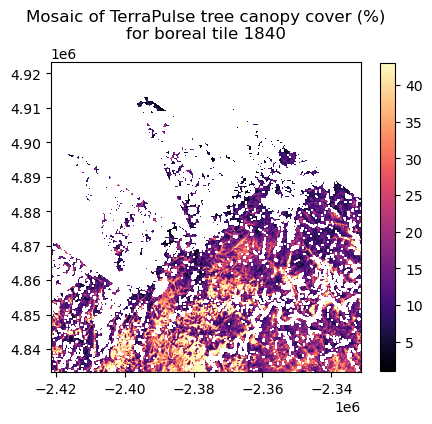

In [218]:
s3_url = footprint_2020_boreal_tcc_unclipped_SUBSET.s3_path.to_list()[5]
local_url = f'/projects/my-public-bucket/local_output/build_stack_tcc2020/tcc2020_{TILE_NUM}_cog.tif'

show_raster(local_url, cmap='magma', VMAX=20, title=f'Mosaic of TerraPulse tree canopy cover (%)\nfor boreal tile {TILE_NUM}')

### Map footprints

In [ ]:
# load natural earth low res shapefile
ne = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# get AOI geometry
country = 'Canada'
geom = ne[ne.name == country].iloc[0].geometry

# get tiles intersecting AOI
tiles = footprint_gdf[footprint_gdf.intersects(geom)]

ax = tiles.to_crs(3857).boundary.plot(color='red')
ax = ne[ne.name == country].boundary.plot(ax=ax, color='black')
ctx.add_basemap(ax)